In [1]:
import pickle
# Load the cleaned S&P 500 DataFrame from a pickle file
with open('data\pickle_files\cleaned_sp500_daily.pkl', 'rb') as file:
    df_sp500 = pickle.load(file)
    
df_sp500.fillna(method='ffill', inplace=True)  # Forward-fill for existing gaps
df_sp500.fillna(method='bfill', inplace=True)  # Backward-fill for leading gaps


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\giuli\AppData\Local\Temp\ipykernel_16896\1581144747.py:3: SyntaxWarning: invalid escape sequence '\p'
  with open('data\pickle_files\cleaned_sp500_daily.pkl', 'rb') as file:
C:\Users\giuli\AppData\Local\Temp\ipykernel_16896\1581144747.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sp500.fillna(method='ffill', inplace=True)  # Forward-fill for existing gaps
C:\Users\giuli\AppData\Local\Temp\ipykernel_16896\1581144747.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sp500.fillna(method='bfill', inplace=True)  # Backward-fill for leading gaps


In [2]:
import numpy as np
import pandas as pd
import time
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


class DTWClustering:
    """
    A class for clustering using Euclidean and FastDTW distances with multiple methods (Hierarchical, KMeans, DBSCAN).

    Parameters:
        df (pd.DataFrame): Input dataframe containing time-series data.

    Methods:
        validate_dataframe(): Validates the input dataframe.
        standardization(): Standardizes the inputs.
        preprocessing(): Computes percentage change and prepares dataframes for clustering and performance analysis.
        hierarchical_clustering(): Performs clustering using hierarchical methods (Euclidean or FastDTW distance).
        kmeans_clustering(): Performs clustering using KMeans (Euclidean or FastDTW distance).
        dbscan_clustering(): Performs clustering using DBSCAN (Euclidean or FastDTW distance).
        plot_dendrogram(): Plots the dendrogram for hierarchical clustering results.
        analyze_clusters(): Calculates silhouette scores and outputs analysis results.
        elbow_method(): Calculates the optimal number of K for kmeans clustering by plotting the curve to find the elbow.
    """

    def __init__(self, df):
        """
        Initialize the DTWClustering object.

        Args:
            df (pd.DataFrame): Input dataframe with time-series data.
        """
        self.df_actual = df
        self.df_pct_change = None
        self.validate_dataframe()

    def validate_dataframe(self):
        """
        Validate the input dataframe to ensure no missing or infinite values.
        """
        if not isinstance(self.df_actual, pd.DataFrame):
            raise ValueError("Input must be a Pandas DataFrame.")
        if self.df_actual.isnull().any().any():
            raise ValueError("Data contains missing values.")
        if not np.isfinite(self.df_actual.values).all():
            raise ValueError("Data contains infinite values.")
        if not np.issubdtype(self.df_actual.dtypes.values[0], np.number):
            raise ValueError("Data contains non-numeric values.")

    def preprocessing(self):
        """
        Transform the input dataframe by computing the percentage change for each value
        relative to the previous row. This creates two dataframes:
        - self.df_actual: The actual values.
        - self.df_pct_change: The percentage change of the actual values.

        Notes:
            - The first row will contain NaN values after the percentage change.
            - NaN values are backward filled to handle missing data.
        """
        # Compute the percentage change
        pct_change_df = self.df_actual.pct_change()

        # Backward fill NaN values that result from the percentage change
        self.df_pct_change = pct_change_df.bfill()

        # Optional: Reset index to keep it clean (if needed)
        self.df_pct_change.reset_index(drop=True, inplace=True)

    def compute_fastdtw_distances(self, df_to_use):
        """
        Compute pairwise FastDTW distances for the dataset.

        Args:
            df_to_use (pd.DataFrame): The dataframe to use for distance calculation (either pct_change or actual values).

        Returns:
            np.ndarray: A condensed distance matrix for hierarchical clustering.
        """
        # Get the number of tickers (columns in df_to_use)
        n = df_to_use.shape[1]
        distances = []

        # Iterate over pairs of columns (tickers)
        for i in range(n):
            for j in range(i + 1, n):
                # Extract the time series for the two tickers (as 1D arrays)
                x = df_to_use.iloc[:, i].values.squeeze()  # Column i
                y = df_to_use.iloc[:, j].values.squeeze()  # Column j

                # Compute the FastDTW distance with Euclidean distance (dist=2)
                dist, _ = fastdtw(x, y, dist=2)
                distances.append(dist)

        return np.array(distances)

    def hierarchical_clustering(self, k=None, distance_metric="euclidean"):
        """
        Perform hierarchical clustering on the percentage change data using a specified distance metric.

        Args:
            k (int, optional): The desired number of clusters. If not provided,
                                the user must specify the value of k.
            distance_metric (str, optional): The distance metric to use for clustering.
                                            Can be one of 'euclidean' or 'fastdtw'.
                                            Default is 'euclidean'.

        Returns:
            dict: A dictionary containing the results of the hierarchical clustering.
                The dictionary includes:
                - 'linkage_matrix' (ndarray): The linkage matrix resulting from the hierarchical clustering.
                - 'clusters' (ndarray): The cluster labels for each data point.
                - 'silhouette' (float or str): The silhouette score of the clustering, or 'N/A' if the score cannot be computed (e.g., for non-Euclidean distance metrics).
                - 'time' (float): The time elapsed during the clustering process, in seconds.
        """
        start_time = time.time()
        data_for_clustering = self.df_pct_change.values.T


        # Calculate pairwise distances
        if distance_metric == "euclidean":
            pairwise_distances = pdist(data_for_clustering, metric="euclidean")  # Condensed matrix
            method = "ward"
        elif distance_metric == "fastdtw":
            pairwise_distances = self.compute_fastdtw_distances(self.df_pct_change)
            method = "average"
        else:
            raise ValueError(f"Unsupported distance metric: {distance_metric}")

        # Perform hierarchical clustering
        Z = linkage(pairwise_distances, method=method)

        # Ensure k is provided for clustering
        if k is None:
            raise ValueError("Please provide a value for k (number of clusters).")

        # Assign cluster labels
        clusters = fcluster(Z, k, criterion="maxclust")

        # Validate that at least 2 clusters are formed
        unique_clusters = len(set(clusters))
        if unique_clusters <= 1:
            raise ValueError(f"Only {unique_clusters} clusters were formed. Adjust k or check your data.")

        # Compute silhouette score only for Euclidean distances
        if distance_metric == "euclidean":
            silhouette = silhouette_score(self.df_pct_change.values.T, clusters, metric="euclidean")
        else:
            silhouette = "N/A"

        elapsed_time = time.time() - start_time

        # Return clustering results
        return {
            "linkage_matrix": Z,
            "clusters": clusters,
            "silhouette": silhouette,
            "time": elapsed_time
        }

    def kmeans_clustering(self, k, distance_metric="euclidean"):
        """
        Perform KMeans clustering using specified distance metric.

        Args:
            k (int): Number of clusters.
            distance_metric (str): Distance metric ('euclidean' or 'fastdtw').

        Returns:
            dict: Clustering results, including cluster labels, silhouette score, and elapsed time.
        """
        if k <= 0:
            raise ValueError("k must be a positive integer.")

        start_time = time.time()

        if distance_metric == "euclidean":
        # Apply KMeans clustering on the percentage change data
            model = KMeans(n_clusters=k)
            clusters = model.fit_predict(self.df_pct_change.values.T)  # Use pct_change data as input
        else:
            raise ValueError("KMeans does not support pairwise distance matrices directly. Consider using another clustering algorithm.")

        # Compute silhouette score
        if distance_metric == "euclidean":
            silhouette = silhouette_score(self.df_pct_change.values.T, clusters, metric="euclidean")
        else:
            silhouette = "N/A"  # Cannot compute silhouette score for non-Euclidean distances
        elapsed_time = time.time() - start_time
        return {"clusters": clusters, "silhouette": silhouette, "time": elapsed_time}

    def dbscan_clustering(self, eps=0.5, min_samples=5, distance_metric="euclidean"):
        """
        Perform DBSCAN clustering using specified distance metric.

        Args:
            eps (float): Maximum distance between two samples to be considered as in the same neighborhood.
            min_samples (int): Minimum number of samples in a neighborhood to form a cluster.
            distance_metric (str): Distance metric ('euclidean' or 'fastdtw').

        Returns:
            dict: Clustering results, including cluster labels and elapsed time.
        """
        start_time = time.time()

        # Compute pairwise distances
        if distance_metric == "euclidean":
            pairwise_distances = pdist(self.df_pct_change.values.T, metric="euclidean")
        elif distance_metric == "fastdtw":
            pairwise_distances = self.compute_fastdtw_distances(self.df_pct_change)
        else:
            raise ValueError("Unsupported distance metric. Use 'euclidean' or 'fastdtw'.")

        # Convert pairwise_distances into a square matrix
        pairwise_distances_square = squareform(pairwise_distances)

        # Apply DBSCAN clustering with the precomputed distance matrix
        model = DBSCAN(metric="precomputed", eps=eps, min_samples=min_samples)
        clusters = model.fit_predict(pairwise_distances_square)

        # Calculate elapsed time
        elapsed_time = time.time() - start_time

        # Optionally, compute silhouette score, excluding noise points (-1)
        if len(set(clusters)) > 1:  # Make sure there is more than one cluster (excluding noise)
            valid_clusters = clusters != -1
            if valid_clusters.any():  # Ensure there are valid points to calculate silhouette score
                silhouette = silhouette_score(self.df_pct_change.values.T[valid_clusters, :], clusters[valid_clusters], metric="euclidean")
            else:
                silhouette = "N/A"
        else:
            silhouette = "N/A"

        return {"clusters": clusters, "silhouette": silhouette, "time": elapsed_time}
    def plot_dendrogram(self, Z, title="Dendrogram"):
        """
        Plot a dendrogram from a linkage matrix.

        Args:
            Z (array): Linkage matrix.
            title (str): Title for the plot.
        """
        plt.figure(figsize=(10, 6))
        dendrogram(Z)
        plt.title(title)
        plt.xlabel("Cluster Size")
        plt.ylabel("Distance")
        plt.show()
    def analyze_clusters(self, clustering_results, k, title_prefix=""):
        """
        Analyze clusters, calculate and display cluster-level statistics based on actual values.

        Args:
            clustering_results (dict): Output from clustering method.
            k (int): Number of clusters.
            title_prefix (str): Prefix for titles in outputs.
        """
        clusters = clustering_results["clusters"]
        cluster_labels = np.unique(clusters)
        stats = []

        for label in cluster_labels:
            idx = np.where(clusters == label)
            cluster_data = self.df_actual.iloc[idx]
            total_return = cluster_data.sum().sum()
            average = cluster_data.mean().mean()
            variance = cluster_data.var().mean()
            stats.append({"Cluster": label, "Total Return": total_return, "Average": average, "Variance": variance})

        stats_df = pd.DataFrame(stats)
        print(f"\n{title_prefix} Cluster Analysis")
        print(stats_df)

    def elbow_method(self, max_k=10):
        """
        Plot the curve to identify the 'elbow' that corresponds to the optimal number of clusters (K).
        """
        sse = []  # Sum of squared errors for each K
        k_rng = range(1, max_k + 1)  # Test K values from 1 to max_k

        # Compute SSE for each value of K
        for k in k_rng:
            kmeans = KMeans(n_clusters=k, random_state=42)  # Random state for reproducibility
            kmeans.fit(self.df_pct_change.values)  # Fit KMeans to the pct_change data
            sse.append(kmeans.inertia_)  # Append the inertia (SSE)

        # Plot the SSE curve
        plt.figure(figsize=(8, 6))  # Set figure size
        plt.plot(k_rng, sse, linewidth=2, marker='o', linestyle='--', color='b')
        plt.title("Elbow Method for Optimal K")
        plt.xlabel("Number of Clusters (K)")
        plt.ylabel("Sum of Squared Errors (SSE)")
        plt.grid(True)  # Add gridlines for better visibility
        plt.xticks(k_rng)  # Ensure all K values appear on the x-axis
        plt.show()

In [3]:
# Take the first 10 timestamps from df_sp500
df_sp500_first_10 = df_sp500.iloc[:10]  # This selects the first 10 rows

df_sp500_first_10

Ticker,TSLA,MLM,POOL,PAYX,JCI,GPC,CAH,AJG,DLTR,HOLX,...,RCL,PRU,GRMN,HAS,ESS,NUE,JBHT,AMAT,ACGL,PYPL
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-14 00:00:00+00:00,15.137333,98.845337,47.631180,31.855057,29.054077,65.548637,56.079235,36.220329,55.880001,23.920000,...,50.171078,52.597412,37.061481,39.956547,137.822662,38.207870,66.783379,16.996983,18.316668,36.709999
2014-10-15 00:00:00+00:00,15.313333,100.631470,47.970528,31.496561,28.512375,65.820229,55.064140,36.089497,55.240002,23.360001,...,48.691025,51.030968,37.849709,39.592178,138.176483,38.254654,66.946983,17.076080,17.916668,36.709999
2014-10-16 00:00:00+00:00,15.090000,104.286591,51.328083,31.525818,28.497742,66.423729,54.236980,35.885101,55.049999,23.150000,...,49.949516,51.660164,38.397095,39.504738,138.235413,38.628853,67.919609,17.462774,17.766666,36.709999
2014-10-17 00:00:00+00:00,15.165333,108.374489,50.801243,31.825790,29.420084,66.800919,55.357380,36.481945,56.580002,23.860001,...,51.145958,53.128288,38.127060,39.242382,137.630951,38.909504,68.092300,17.471556,18.123333,36.709999
2014-10-20 00:00:00+00:00,15.364667,110.114586,51.337040,32.008709,29.398130,67.472343,55.725842,36.694550,57.340000,24.010000,...,54.265591,53.088989,38.550365,41.180832,139.798157,39.353878,68.046844,17.638535,18.240000,36.709999
2014-10-21 00:00:00+00:00,15.689333,111.458763,52.194275,32.689106,29.939829,69.946709,57.019157,37.005241,58.130001,24.760000,...,56.241947,54.806187,39.302094,42.062592,141.441986,40.297188,69.937569,18.262526,18.549999,36.709999
2014-10-22 00:00:00+00:00,15.406667,109.838356,51.560272,32.711060,29.469252,69.954254,57.146980,37.037941,57.560001,24.309999,...,56.206505,53.993454,39.119648,41.472317,142.238068,40.312782,69.792099,18.007656,18.553333,36.709999
2014-10-23 00:00:00+00:00,15.686000,111.845474,52.087135,32.930553,30.167761,70.007065,57.485340,37.095177,58.509998,24.770000,...,55.205021,54.563679,39.579449,41.887688,143.218475,39.852818,70.482941,18.367979,18.386667,36.709999
2014-10-24 00:00:00+00:00,15.682667,113.180481,51.595978,33.281738,30.579508,70.301285,57.974121,37.446751,58.939999,24.940001,...,57.207970,55.435390,40.331184,41.982441,143.085800,41.154739,70.301147,18.447090,18.559999,36.709999


In [35]:
# Initialize the DTWClustering with the sliced DataFrame
dtw_clustering = DTWClustering(df_sp500)

dtw_clustering.preprocessing()

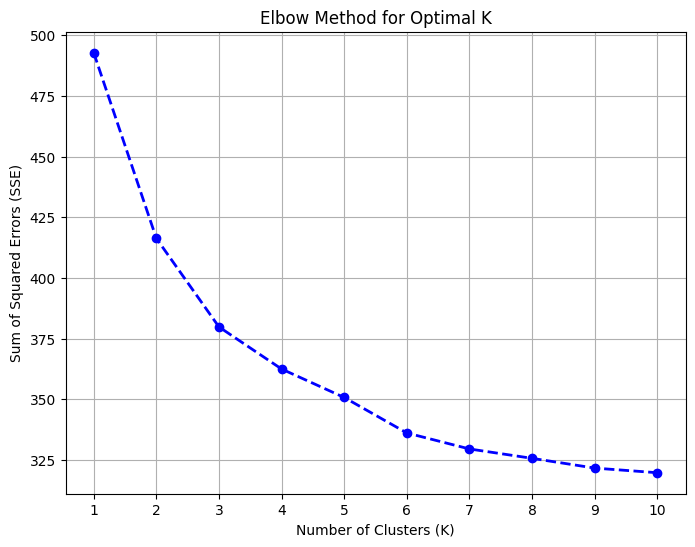

In [36]:
#elbow method for kmeans clustering
dtw_clustering.elbow_method()

In [38]:
# Hierarchical Clustering with FastDTW Distance
print("\nHierarchical Clustering with FastDTW Distance:")
hierarchical_results_fastdtw = dtw_clustering.hierarchical_clustering(k=4, distance_metric="fastdtw")

print(hierarchical_results_fastdtw)


Hierarchical Clustering with FastDTW Distance:


KeyboardInterrupt: 

In [ ]:
hierarchical_cluster_fastDTW=hierarchical_results_fastdtw["clusters"] -1
hierarchical_cluster_fastDTW

In [39]:
# Hierarchical Clustering with Euclidean Distance
print("\nHierarchical Clustering with Euclidean Distance:")
hierarchical_results_euclidean = dtw_clustering.hierarchical_clustering(k=4, distance_metric="euclidean")

print(hierarchical_results_euclidean)


Hierarchical Clustering with Euclidean Distance:
{'linkage_matrix': array([[1.66000000e+02, 2.90000000e+02, 3.04046069e-01, 2.00000000e+00],
       [4.40000000e+01, 1.26000000e+02, 3.17744307e-01, 2.00000000e+00],
       [3.73000000e+02, 4.15000000e+02, 3.18292185e-01, 2.00000000e+00],
       ...,
       [9.22000000e+02, 9.32000000e+02, 4.85515054e+00, 1.90000000e+02],
       [9.31000000e+02, 9.34000000e+02, 5.29260766e+00, 2.44000000e+02],
       [9.33000000e+02, 9.35000000e+02, 5.99018336e+00, 4.69000000e+02]]), 'clusters': array([2, 4, 4, 1, 4, 4, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 3, 4, 1, 4, 4,
       1, 4, 4, 2, 4, 4, 2, 3, 1, 1, 4, 4, 1, 4, 4, 4, 1, 1, 4, 1, 4, 1,
       1, 1, 1, 4, 1, 4, 3, 1, 1, 2, 2, 4, 4, 1, 1, 1, 1, 4, 4, 4, 2, 2,
       4, 1, 4, 1, 1, 4, 1, 4, 1, 4, 4, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 2,
       2, 4, 1, 1, 1, 4, 1, 1, 1, 2, 1, 4, 4, 4, 1, 3, 1, 3, 1, 4, 1, 4,
       1, 1, 1, 2, 4, 1, 1, 1, 4, 4, 1, 4, 4, 2, 1, 3, 1, 4, 4, 2, 1, 4,
       4, 2, 3, 1, 1, 2, 1, 1

In [40]:
hierarchical_cluster_euclidean=hierarchical_results_euclidean["clusters"] -1
hierarchical_cluster_euclidean

array([1, 3, 3, 0, 3, 3, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 2, 3, 0, 3, 3,
       0, 3, 3, 1, 3, 3, 1, 2, 0, 0, 3, 3, 0, 3, 3, 3, 0, 0, 3, 0, 3, 0,
       0, 0, 0, 3, 0, 3, 2, 0, 0, 1, 1, 3, 3, 0, 0, 0, 0, 3, 3, 3, 1, 1,
       3, 0, 3, 0, 0, 3, 0, 3, 0, 3, 3, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1,
       1, 3, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 3, 3, 0, 2, 0, 2, 0, 3, 0, 3,
       0, 0, 0, 1, 3, 0, 0, 0, 3, 3, 0, 3, 3, 1, 0, 2, 0, 3, 3, 1, 0, 3,
       3, 1, 2, 0, 0, 1, 0, 0, 1, 3, 3, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 3,
       3, 0, 0, 0, 3, 3, 0, 0, 3, 3, 1, 3, 0, 3, 0, 0, 1, 1, 0, 3, 3, 1,
       0, 0, 2, 3, 0, 1, 3, 1, 0, 3, 0, 0, 0, 0, 1, 0, 0, 3, 1, 3, 0, 0,
       0, 2, 1, 0, 3, 0, 3, 3, 0, 0, 1, 3, 2, 3, 0, 3, 2, 3, 3, 0, 0, 3,
       3, 1, 0, 0, 3, 3, 0, 0, 3, 0, 0, 0, 3, 3, 2, 0, 3, 0, 0, 0, 3, 3,
       0, 0, 0, 1, 0, 3, 0, 1, 3, 0, 0, 0, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3,
       0, 3, 3, 3, 0, 3, 1, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 2,
       0, 0, 3, 1, 0, 0, 3, 0, 3, 1, 3, 3, 0, 0, 3,

In [50]:
# KMeans Clustering with Euclidean Distance
print("\nKMeans Clustering with Euclidean Distance:")
kmeans_results_euclidean = dtw_clustering.kmeans_clustering(k=4, distance_metric="euclidean")
print(kmeans_results_euclidean)


KMeans Clustering with Euclidean Distance:
{'clusters': array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1, 0,
       0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 2, 0, 1, 1, 0, 3, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 2, 3, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 

In [51]:
kmeans_cluster_euclidean=kmeans_results_euclidean["clusters"]
kmeans_cluster_euclidean

array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1, 0,
       0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 2, 0, 1, 1, 0, 3, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 2, 3, 1, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,

In [52]:
dtw_clustering_transposed_actual_values=dtw_clustering.df_actual.T
dtw_clustering_transposed_actual_values

Date,2014-10-14 00:00:00+00:00,2014-10-15 00:00:00+00:00,2014-10-16 00:00:00+00:00,2014-10-17 00:00:00+00:00,2014-10-20 00:00:00+00:00,2014-10-21 00:00:00+00:00,2014-10-22 00:00:00+00:00,2014-10-23 00:00:00+00:00,2014-10-24 00:00:00+00:00,2014-10-27 00:00:00+00:00,...,2024-09-30 00:00:00+00:00,2024-10-01 00:00:00+00:00,2024-10-02 00:00:00+00:00,2024-10-03 00:00:00+00:00,2024-10-04 00:00:00+00:00,2024-10-07 00:00:00+00:00,2024-10-08 00:00:00+00:00,2024-10-09 00:00:00+00:00,2024-10-10 00:00:00+00:00,2024-10-11 00:00:00+00:00
Ticker,,,,,,,,,,,,,,,,,,,,,
TSLA,15.137333,15.313333,15.090000,15.165333,15.364667,15.689333,15.406667,15.686000,15.682667,14.778000,...,261.630005,258.019989,249.020004,240.660004,250.080002,240.830002,244.500000,241.050003,238.770004,217.800003
MLM,98.845337,100.631470,104.286591,108.374489,110.114586,111.458763,109.838356,111.845474,113.180481,111.053703,...,538.250000,534.979980,521.049988,521.229980,524.109985,518.650024,523.989990,531.159973,534.520020,544.900024
POOL,47.631180,47.970528,51.328083,50.801243,51.337040,52.194275,51.560272,52.087135,51.595978,51.515621,...,376.799988,375.609985,372.769989,371.450012,363.910004,363.019989,364.940002,365.739990,362.500000,365.279999
PAYX,31.855057,31.496561,31.525818,31.825790,32.008709,32.689106,32.711060,32.930553,33.281738,33.486584,...,133.304977,139.861435,139.831635,138.440872,137.735550,136.533539,137.248795,138.917709,138.371338,137.973984
JCI,29.054077,28.512375,28.497742,29.420084,29.398130,29.939829,29.469252,30.167761,30.579508,30.439816,...,77.610001,76.809998,76.570000,75.489998,75.680000,75.550003,76.349998,77.699997,76.919998,77.610001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NUE,38.207870,38.254654,38.628853,38.909504,39.353878,40.297188,40.312782,39.852818,41.154739,40.694775,...,150.339996,152.710007,151.449997,151.289993,151.440002,152.750000,148.110001,151.820007,150.899994,151.910004
JBHT,66.783379,66.946983,67.919609,68.092300,68.046844,69.937569,69.792099,70.482941,70.301147,71.155602,...,171.936905,169.213135,167.756454,166.349670,164.144730,163.845398,164.902985,165.711136,165.541519,170.330582
AMAT,16.996983,17.076080,17.462774,17.471556,17.638535,18.262526,18.007656,18.367979,18.447090,18.491028,...,202.050003,197.199997,201.149994,199.589996,201.970001,200.130005,200.880005,205.059998,203.960007,205.059998


In [53]:
dtw_clustering_transposed_actual_values['Hierarchical_Cluster_euclidean'] = hierarchical_cluster_euclidean
#dtw_clustering_transposed_actual_values['Hierarchical_Cluster_DTW'] = hierarchical_cluster_fastDTW
dtw_clustering_transposed_actual_values['KMeans_Cluster'] = kmeans_cluster_euclidean

In [54]:
dtw_clustering_transposed_actual_values

Date,2014-10-14 00:00:00+00:00,2014-10-15 00:00:00+00:00,2014-10-16 00:00:00+00:00,2014-10-17 00:00:00+00:00,2014-10-20 00:00:00+00:00,2014-10-21 00:00:00+00:00,2014-10-22 00:00:00+00:00,2014-10-23 00:00:00+00:00,2014-10-24 00:00:00+00:00,2014-10-27 00:00:00+00:00,...,2024-10-02 00:00:00+00:00,2024-10-03 00:00:00+00:00,2024-10-04 00:00:00+00:00,2024-10-07 00:00:00+00:00,2024-10-08 00:00:00+00:00,2024-10-09 00:00:00+00:00,2024-10-10 00:00:00+00:00,2024-10-11 00:00:00+00:00,Hierarchical_Cluster_euclidean,KMeans_Cluster
Ticker,,,,,,,,,,,,,,,,,,,,,
TSLA,15.137333,15.313333,15.090000,15.165333,15.364667,15.689333,15.406667,15.686000,15.682667,14.778000,...,249.020004,240.660004,250.080002,240.830002,244.500000,241.050003,238.770004,217.800003,1,0
MLM,98.845337,100.631470,104.286591,108.374489,110.114586,111.458763,109.838356,111.845474,113.180481,111.053703,...,521.049988,521.229980,524.109985,518.650024,523.989990,531.159973,534.520020,544.900024,3,0
POOL,47.631180,47.970528,51.328083,50.801243,51.337040,52.194275,51.560272,52.087135,51.595978,51.515621,...,372.769989,371.450012,363.910004,363.019989,364.940002,365.739990,362.500000,365.279999,3,1
PAYX,31.855057,31.496561,31.525818,31.825790,32.008709,32.689106,32.711060,32.930553,33.281738,33.486584,...,139.831635,138.440872,137.735550,136.533539,137.248795,138.917709,138.371338,137.973984,0,1
JCI,29.054077,28.512375,28.497742,29.420084,29.398130,29.939829,29.469252,30.167761,30.579508,30.439816,...,76.570000,75.489998,75.680000,75.550003,76.349998,77.699997,76.919998,77.610001,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NUE,38.207870,38.254654,38.628853,38.909504,39.353878,40.297188,40.312782,39.852818,41.154739,40.694775,...,151.449997,151.289993,151.440002,152.750000,148.110001,151.820007,150.899994,151.910004,3,0
JBHT,66.783379,66.946983,67.919609,68.092300,68.046844,69.937569,69.792099,70.482941,70.301147,71.155602,...,167.756454,166.349670,164.144730,163.845398,164.902985,165.711136,165.541519,170.330582,3,1
AMAT,16.996983,17.076080,17.462774,17.471556,17.638535,18.262526,18.007656,18.367979,18.447090,18.491028,...,201.149994,199.589996,201.970001,200.130005,200.880005,205.059998,203.960007,205.059998,1,0


In [55]:
dtw_clustering_transposed_pct_change=dtw_clustering.df_pct_change.T
dtw_clustering_transposed_pct_change

,0,1,2,3,4,5,6,7,8,9,...,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515
Ticker,,,,,,,,,,,,,,,,,,,,,
TSLA,0.011627,0.011627,-0.014584,0.004992,0.013144,0.021131,-0.018016,0.018131,-0.000212,-0.057686,...,0.004492,-0.013798,-0.034881,-0.033572,0.039142,-0.036988,0.015239,-0.014110,-0.009459,-0.087825
MLM,0.018070,0.018070,0.036322,0.039199,0.016056,0.012207,-0.014538,0.018273,0.011936,-0.018791,...,-0.001595,-0.006075,-0.026038,0.000345,0.005525,-0.010418,0.010296,0.013683,0.006326,0.019419
POOL,0.007124,0.007124,0.069992,-0.010264,0.010547,0.016698,-0.012147,0.010218,-0.009430,-0.001557,...,0.011435,-0.003158,-0.007561,-0.003541,-0.020299,-0.002446,0.005289,0.002192,-0.008859,0.007669
PAYX,-0.011254,-0.011254,0.000929,0.009515,0.005747,0.021257,0.000672,0.006710,0.010664,0.006155,...,0.009023,0.049184,-0.000213,-0.009946,-0.005095,-0.008727,0.005239,0.012160,-0.003933,-0.002872
JCI,-0.018645,-0.018645,-0.000513,0.032365,-0.000746,0.018426,-0.015717,0.023703,0.013649,-0.004568,...,0.005181,-0.010308,-0.003125,-0.014105,0.002517,-0.001718,0.010589,0.017682,-0.010039,0.008970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NUE,0.001224,0.001224,0.009782,0.007265,0.011421,0.023970,0.000387,-0.011410,0.032668,-0.011176,...,0.001399,0.015764,-0.008251,-0.001056,0.000992,0.008650,-0.030376,0.025049,-0.006060,0.006693
JBHT,0.002450,0.002450,0.014528,0.002543,-0.000668,0.027786,-0.002080,0.009899,-0.002579,0.012154,...,-0.000116,-0.015842,-0.008609,-0.008386,-0.013255,-0.001824,0.006455,0.004901,-0.001024,0.028930
AMAT,0.004654,0.004654,0.022645,0.000503,0.009557,0.035377,-0.013956,0.020009,0.004307,0.002382,...,-0.014005,-0.024004,0.020030,-0.007755,0.011924,-0.009110,0.003748,0.020808,-0.005364,0.005393


In [56]:
dtw_clustering_transposed_pct_change['Hierarchical_Cluster_euclidean'] = hierarchical_cluster_euclidean
#dtw_clustering_transposed_pct_change['Hierarchical_Cluster_DTW'] = hierarchical_cluster_fastDTW
dtw_clustering_transposed_pct_change['KMeans_Cluster'] = kmeans_cluster_euclidean

In [57]:
dtw_clustering_transposed_pct_change

,0,1,2,3,4,5,6,7,8,9,...,2508,2509,2510,2511,2512,2513,2514,2515,Hierarchical_Cluster_euclidean,KMeans_Cluster
Ticker,,,,,,,,,,,,,,,,,,,,,
TSLA,0.011627,0.011627,-0.014584,0.004992,0.013144,0.021131,-0.018016,0.018131,-0.000212,-0.057686,...,-0.034881,-0.033572,0.039142,-0.036988,0.015239,-0.014110,-0.009459,-0.087825,1,0
MLM,0.018070,0.018070,0.036322,0.039199,0.016056,0.012207,-0.014538,0.018273,0.011936,-0.018791,...,-0.026038,0.000345,0.005525,-0.010418,0.010296,0.013683,0.006326,0.019419,3,0
POOL,0.007124,0.007124,0.069992,-0.010264,0.010547,0.016698,-0.012147,0.010218,-0.009430,-0.001557,...,-0.007561,-0.003541,-0.020299,-0.002446,0.005289,0.002192,-0.008859,0.007669,3,1
PAYX,-0.011254,-0.011254,0.000929,0.009515,0.005747,0.021257,0.000672,0.006710,0.010664,0.006155,...,-0.000213,-0.009946,-0.005095,-0.008727,0.005239,0.012160,-0.003933,-0.002872,0,1
JCI,-0.018645,-0.018645,-0.000513,0.032365,-0.000746,0.018426,-0.015717,0.023703,0.013649,-0.004568,...,-0.003125,-0.014105,0.002517,-0.001718,0.010589,0.017682,-0.010039,0.008970,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NUE,0.001224,0.001224,0.009782,0.007265,0.011421,0.023970,0.000387,-0.011410,0.032668,-0.011176,...,-0.008251,-0.001056,0.000992,0.008650,-0.030376,0.025049,-0.006060,0.006693,3,0
JBHT,0.002450,0.002450,0.014528,0.002543,-0.000668,0.027786,-0.002080,0.009899,-0.002579,0.012154,...,-0.008609,-0.008386,-0.013255,-0.001824,0.006455,0.004901,-0.001024,0.028930,3,1
AMAT,0.004654,0.004654,0.022645,0.000503,0.009557,0.035377,-0.013956,0.020009,0.004307,0.002382,...,0.020030,-0.007755,0.011924,-0.009110,0.003748,0.020808,-0.005364,0.005393,1,0



Plotting Dendrogram for Euclidean Hierarchical Clustering:


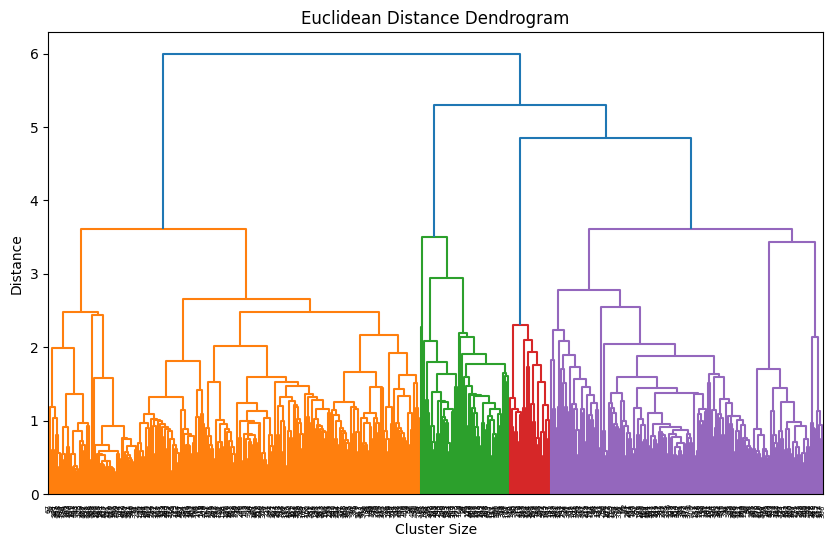


Plotting Dendrogram for FastDTW Hierarchical Clustering:

Cluster Analysis for Euclidean Hierarchical Clustering:

Euclidean Hierarchical Cluster Analysis
   Cluster  Total Return    Average    Variance
0        1  6.895287e+06  65.342688  193.600720
1        2  1.660709e+06  65.573289  193.299581
2        3  7.692119e+05  65.604422  188.499880
3        4  5.032889e+06  65.037013  191.871491

Cluster Analysis for FastDTW Hierarchical Clustering:


NameError: name 'hierarchical_results_fastdtw' is not defined

In [58]:
# Plot dendrograms
print("\nPlotting Dendrogram for Euclidean Hierarchical Clustering:")
dtw_clustering.plot_dendrogram(hierarchical_results_euclidean["linkage_matrix"], title="Euclidean Distance Dendrogram")

print("\nPlotting Dendrogram for FastDTW Hierarchical Clustering:")
#dtw_clustering.plot_dendrogram(hierarchical_results_fastdtw["linkage_matrix"], title="FastDTW Distance Dendrogram")

# Analyze clusters for both hierarchical methods
print("\nCluster Analysis for Euclidean Hierarchical Clustering:")
dtw_clustering.analyze_clusters(hierarchical_results_euclidean, k=2, title_prefix="Euclidean Hierarchical")

print("\nCluster Analysis for FastDTW Hierarchical Clustering:")
dtw_clustering.analyze_clusters(hierarchical_results_fastdtw, k=2, title_prefix="FastDTW Hierarchical")

In [70]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cluster_timeseries(df_actual, df_pct, clustering_columns):
    """
    Plots the time series of tickers in each cluster for both actual values and pct change values.
    
    Args:
    - df_actual (pd.DataFrame): Dataframe containing actual values with tickers as rows and timestamps as columns.
    - df_pct (pd.DataFrame): Dataframe containing percentage change values with tickers as rows and timestamps as columns.
    - clustering_columns (list): List of column names corresponding to the clustering algorithms.
    
    Returns:
    - None
    """
    
    # Iterate over each clustering type (one column for each clustering algorithm)
    for clustering_col in clustering_columns:
        # Get unique clusters
        clusters = df_actual[clustering_col].unique()
        num_clusters = len(clusters)

        # Set number of rows and columns: 2 rows per cluster (one for actual, one for pct change)
        nrows = num_clusters  # One row per cluster
        ncols = 2  # Two columns (one for actual, one for pct change)

        # Create figure with appropriate size
        plt.figure(figsize=(18, 5 * num_clusters))  # Adjust the size for multiple rows

        plt.suptitle(f"Cluster Timeseries for {clustering_col}", fontsize=16)

        # Plot actual values for each cluster (first column)
        for idx, cluster in enumerate(clusters):
            tickers_in_cluster = df_actual[df_actual[clustering_col] == cluster].index
            df_cluster_actual = df_actual.loc[tickers_in_cluster].drop(columns=[clustering_col])

            if not df_cluster_actual.empty:
                ax = plt.subplot(nrows, ncols, idx * 2 + 1)  # First column for actual values
                df_cluster_actual.transpose().plot(title=f"Cluster {cluster} - Actual", ax=ax, legend = False)
                ax.set_xlabel('')  # Hide x-axis label
                ax.set_ylabel('')  # Hide y-axis label
                ax.set_xticks([])  # Remove x-axis ticks (no tick marks)
                ax.set_xticklabels([])  # Remove x-axis labels (no tick labels)
        
        # Plot pct change values for each cluster (second column)
        for idx, cluster in enumerate(clusters):
            tickers_in_cluster = df_pct[df_pct[clustering_col] == cluster].index
            df_cluster_pct = df_pct.loc[tickers_in_cluster].drop(columns=[clustering_col])

            if not df_cluster_pct.empty:
                ax = plt.subplot(nrows, ncols, idx * 2 + 2)  # Second column for pct change
                df_cluster_pct.transpose().plot(title=f"Cluster {cluster} - % Change", ax=ax, legend = False)
                ax.set_xlabel('')  # Hide x-axis label
                ax.set_ylabel('')  # Hide y-axis label
                ax.set_xticks([])  # Remove x-axis ticks (no tick marks)
                ax.set_xticklabels([])  # Remove x-axis labels (no tick labels)
        
        # Adjust layout to be more spacious
        plt.tight_layout(pad=4.0, rect=[0, 0, 1, 0.95])  # Increase the pad for more space
        plt.show()



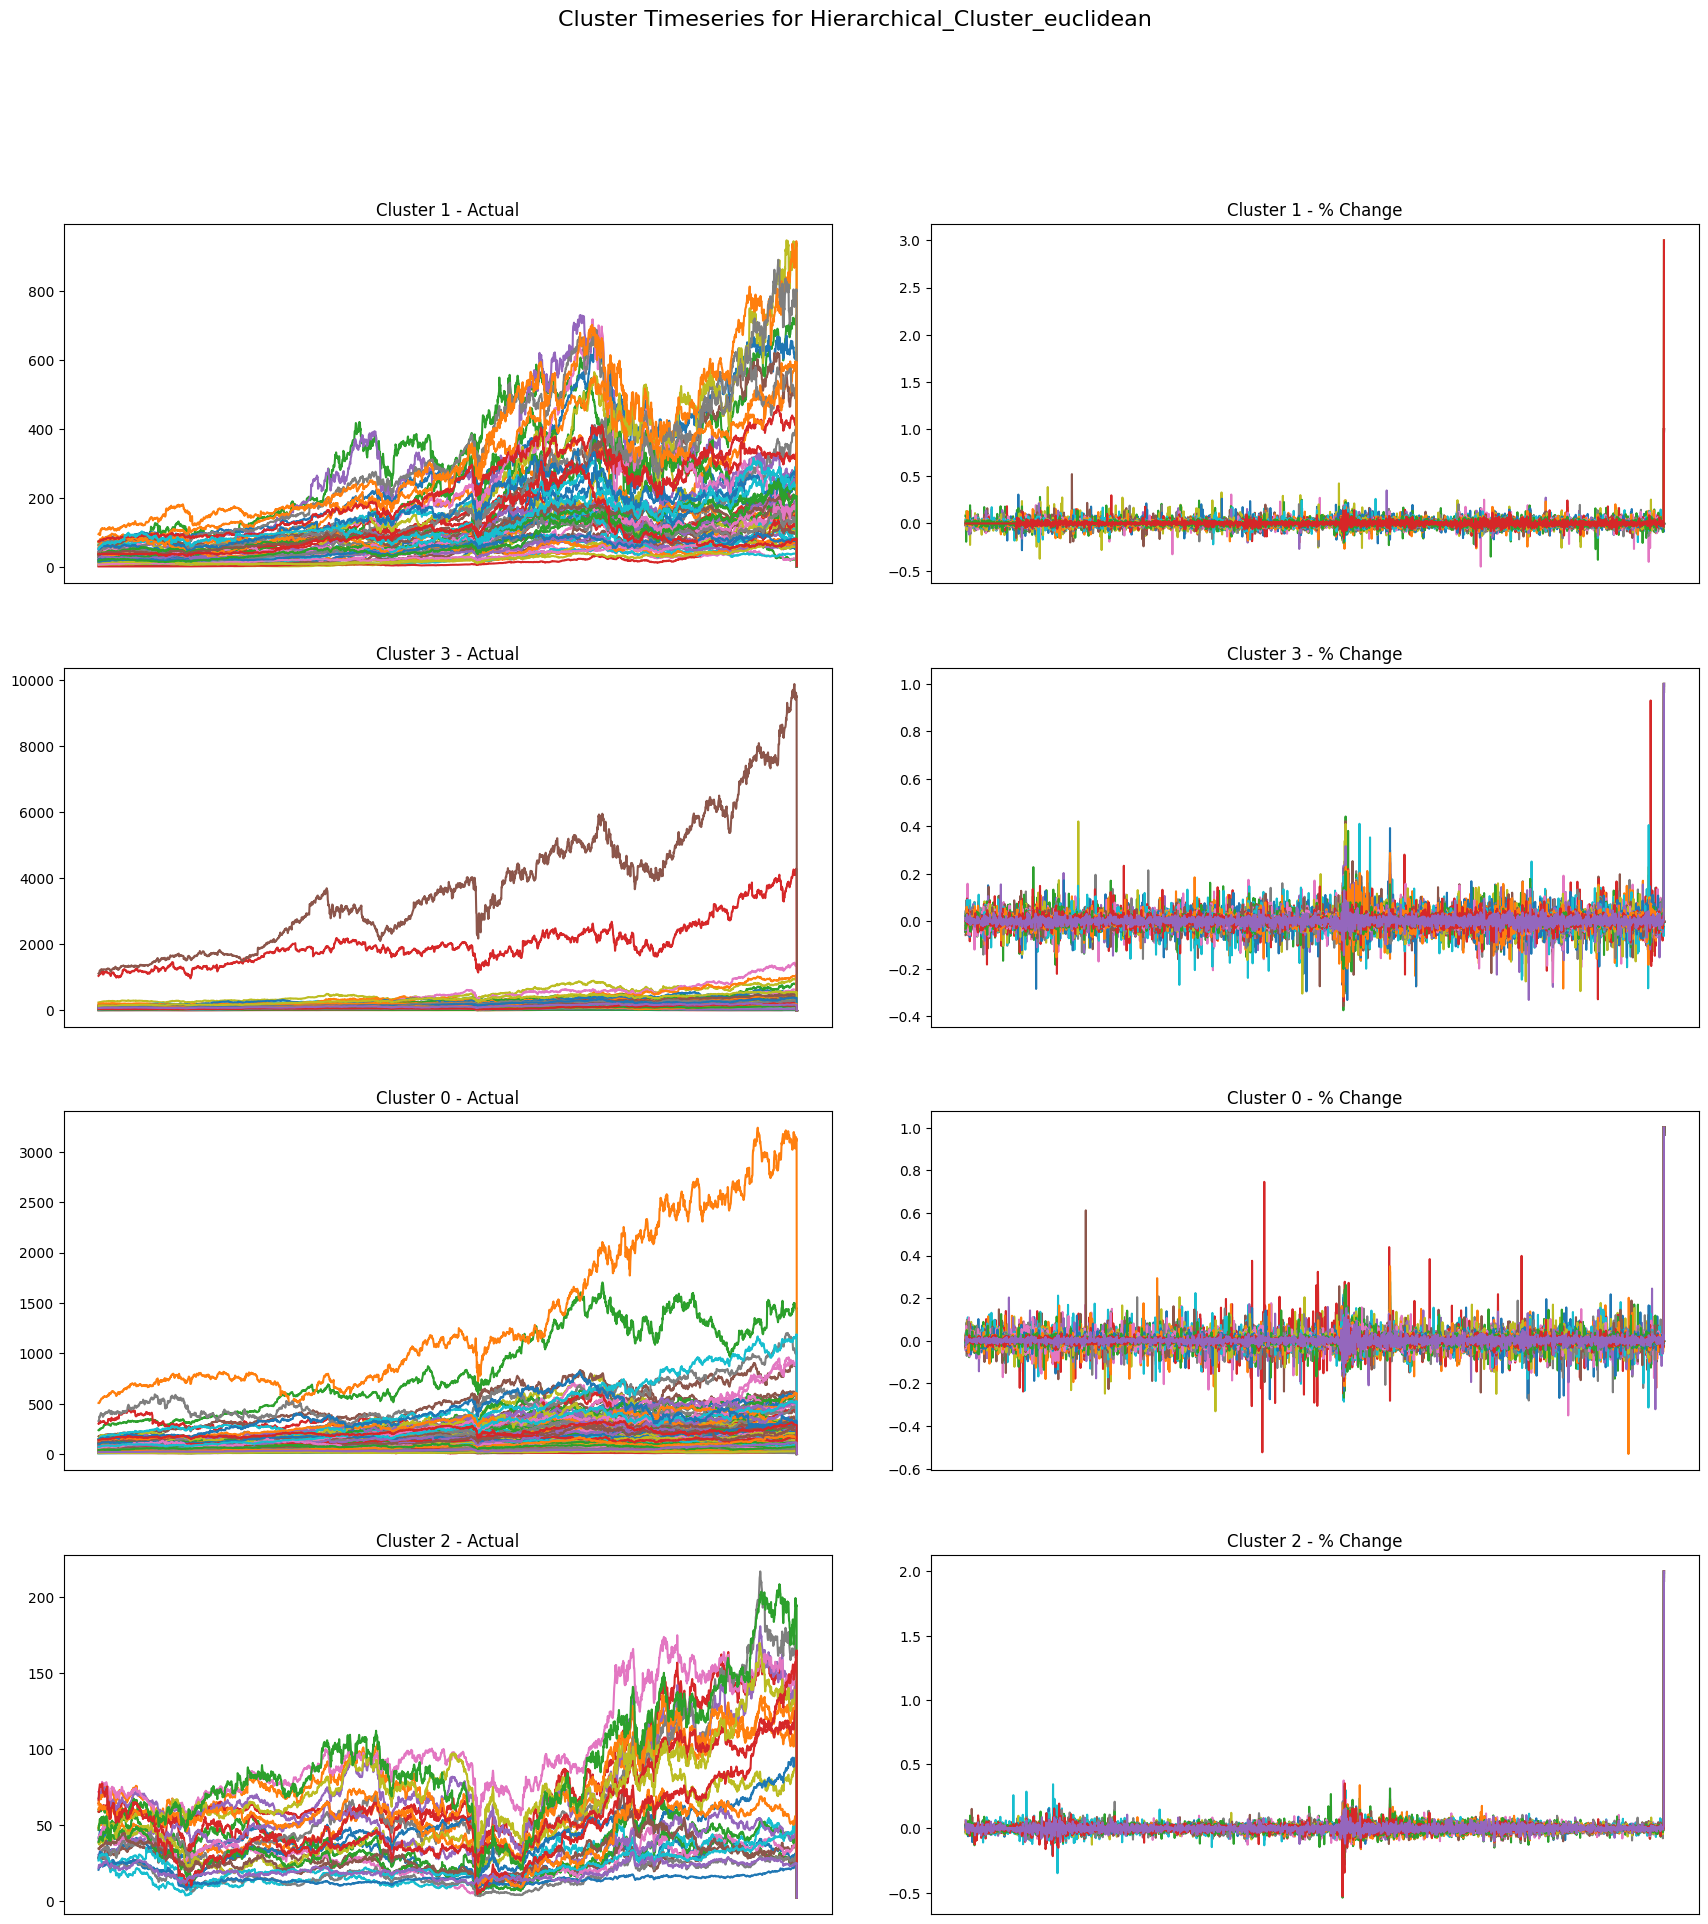

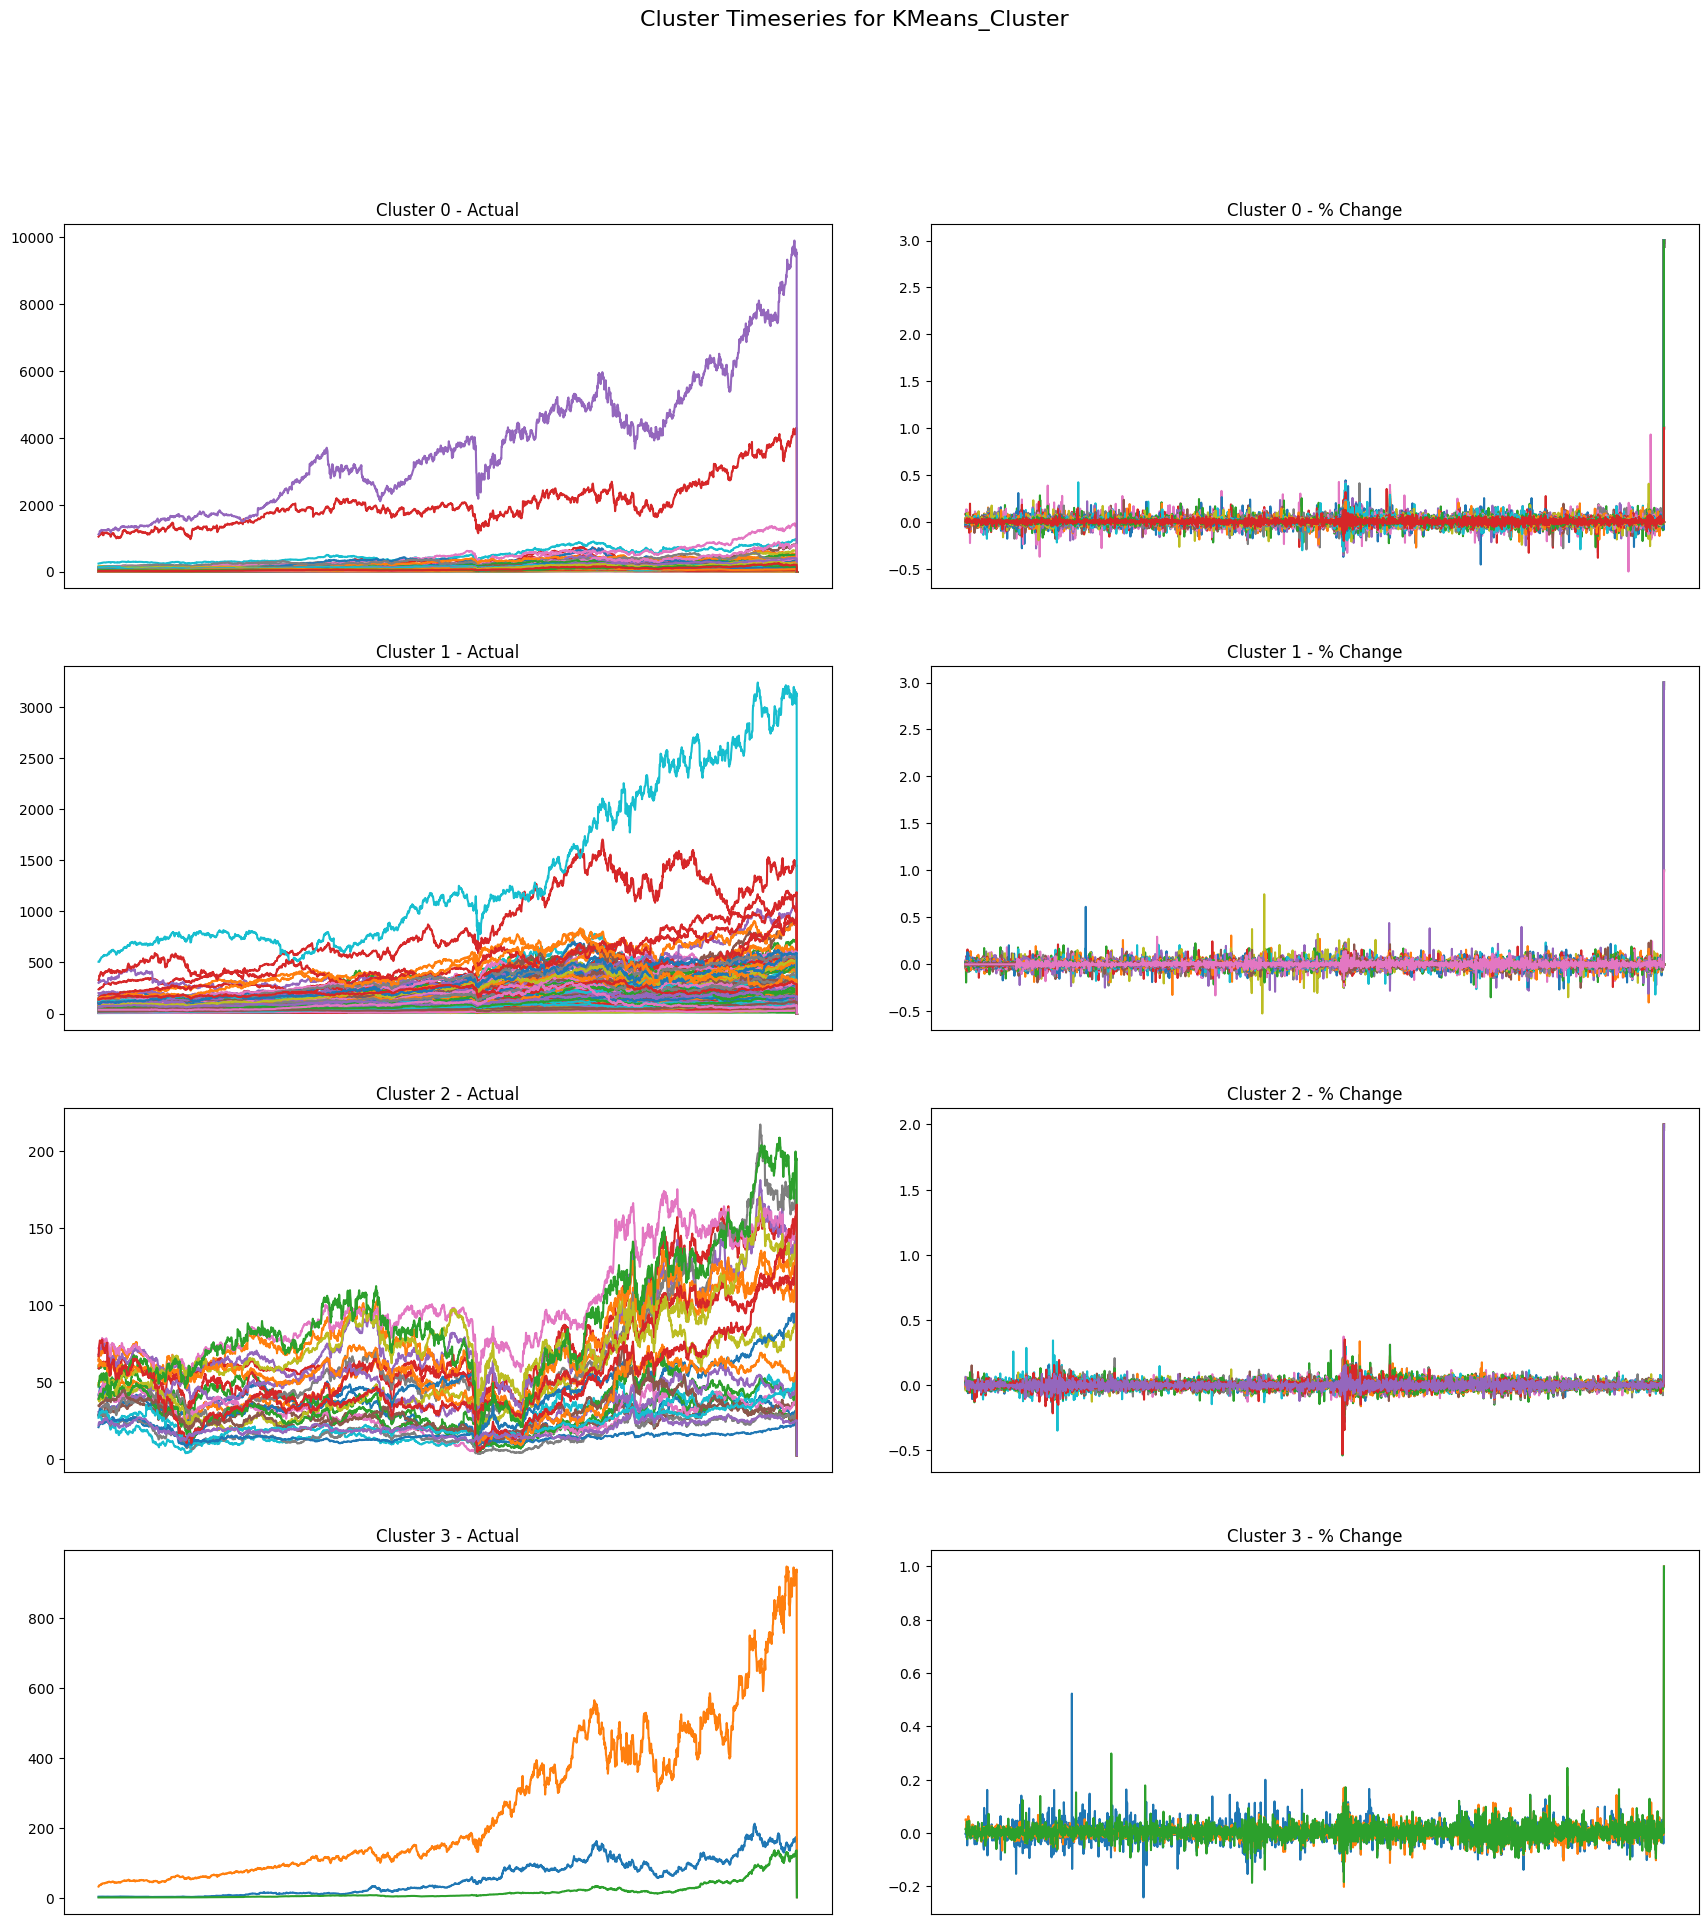

In [71]:
# Example usage:
# Assuming `df_actual` and `df_pct` are your dataframes containing the actual values and percentage change values, respectively.
# Also assuming the clustering columns are named 'clustering_type_1', 'clustering_type_2', and 'clustering_type_3'.
clustering_columns = ['Hierarchical_Cluster_euclidean', 'KMeans_Cluster']
plot_cluster_timeseries(dtw_clustering_transposed_actual_values, dtw_clustering_transposed_pct_change, clustering_columns)

